In [2]:
import pandas as pd
import numpy as np
import os
import re
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Load and Combine CSV Files
def load_and_combine_csv_files(csv_folder_path):

    df_list = [] # Initialize an empty list for DataFrames
    csv_files = glob.glob(os.path.join(csv_folder_path, '*.csv')) #Get all CSV files in the directory

    # Define regular expression pattern to extract parameters from filenames
    # Matches: Results_Rebate123_Baseline456_CongDays7_8_Hours9_10.csv
    # Group 1 (\d+): Captures Rebate number (e.g., 123)
    # Group 2 (\d+): Captures Baseline number (e.g., 456)
    # Group 3 ([_\d]*): Captures CongDays values (e.g., 7_8)
    # Group 4 ([_\d]*): Captures Hours values (e.g., 9_10)
    filename_pattern = r'Results_Rebate(\d+)_Baseline(\d+)_CongDays([_\d]*)_Hours([_\d]*).csv'

    # Loop through each file
    for file in csv_files:
        # Extract parameter values from the filename
        match = re.search(filename_pattern, os.path.basename(file)) #Basename without path, filename_pattern based on regular expression
        if match:
            # Store extracted group values Group 1: Rebate, Group 2: Lookback, Group 3: CongDays, Group 4: CongHours
            cong_rebate = int(match.group(1))
            baseline_lookback = int(match.group(2))
            cong_days_str = match.group(3)
            cong_hours_str = match.group(4)
            
            # Convert cong_days_str and cong_hours_str to lists
            cong_days_list = [int(day) for day in cong_days_str.strip('_').split('_') if day] # 0_3_5 -> [0,3,5]
            num_cong_weekdays = len(cong_days_list)
            cong_hours_list = [int(hour) for hour in cong_hours_str.strip('_').split('_') if hour] # 0_3_5 -> [0,3,5]
        else:
            continue  # Skip files that don't match the pattern
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Add parameter columns to the DataFrame
        df['Cong_Rebate'] = cong_rebate
        df['Baseline_Lookback'] = baseline_lookback
        df['Num_Cong_Weekdays'] = num_cong_weekdays
        df['Cong_Days'] = str(cong_days_list)
        df['Cong_Hours'] = str(cong_hours_list)
        
        # Append the DataFrame to the list
        df_list.append(df)

    # Concatenate all DataFrames into a single DataFrame
    all_results_df = pd.concat(df_list, ignore_index=True)
    all_results_df['Time'] = pd.to_datetime(all_results_df['Time'])

    return all_results_df

csv_folder_path = '../../data/bess_results/Run1'
all_results_df = load_and_combine_csv_files(csv_folder_path)

In [4]:
# Step 2: Calculate Baseline Shift Magnitude
def calculate_baseline_shift(all_results_df):

    # Separate 'Cong' and 'NoCong' scenarios
    # IMPORTANT - Only consider valid baseline days (no congestion), as here the shift is unwanted -> manipulation
    cong_df = all_results_df[(all_results_df['Scenario'] == 'Cong') & (all_results_df['Valid_Baseline_Day'] == 1)].copy()
    nocong_df = all_results_df[(all_results_df['Scenario'] == 'NoCong') & (all_results_df['Valid_Baseline_Day'] == 1)].copy()

    # Merge the two DataFrames on common columns
    merge_columns = ['EMS_ID', 'Time', 'Cong_Rebate', 'Baseline_Lookback', 'Num_Cong_Weekdays', 'Cong_Days', 'Cong_Hours']
    comparison_df = pd.merge(cong_df, nocong_df, on=merge_columns, suffixes=('_Cong', '_NoCong'))

    # Calculate the baseline shift magnitude
    comparison_df['Baseline_Shift'] = comparison_df['NetConsumption_Optimized_Cong'] - comparison_df['NetConsumption_Optimized_NoCong']
    comparison_df['Baseline_Shift_Abs'] = comparison_df['Baseline_Shift'].abs()
    
    # Extract the hour from the 'Time' column
    comparison_df['Hour'] = comparison_df['Time'].dt.hour

    return comparison_df

comparison_df = calculate_baseline_shift(all_results_df)

### Heatmap

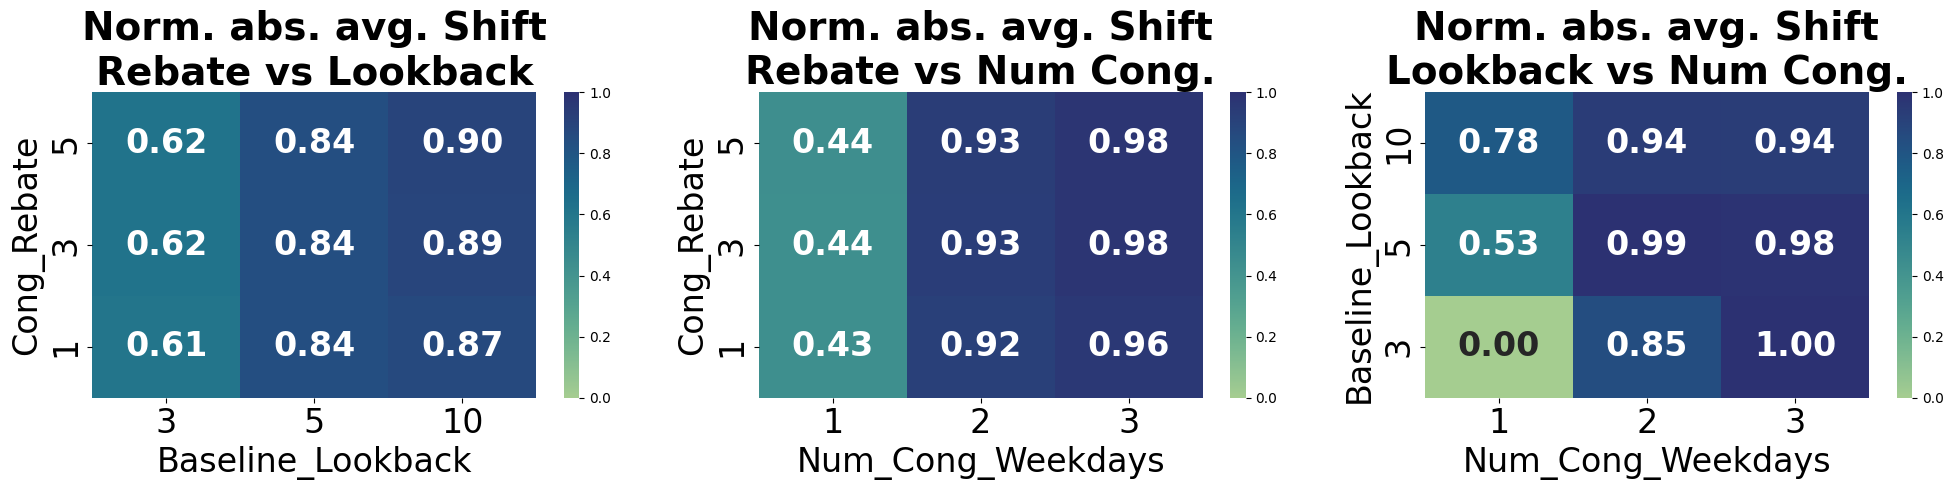

In [9]:
# Step 3: Prepare Data for Heatmaps
def prepare_data_for_heatmap(comparison_df):

    # Group by parameters and calculate mean absolute baseline shift
    #This step groups the data by the three parameters and calculates the sum of the absolute baseline shift for each group.
    grouped = comparison_df.groupby(['Cong_Rebate', 'Baseline_Lookback', 'Num_Cong_Weekdays'])['Baseline_Shift_Abs'].mean().reset_index()

    # Prepare data for the three heatmaps by creating aggregated pivot tables
    # Heatmap 1: Rebate vs Baseline Lookback
    heatmap_data1 = grouped.pivot_table(values='Baseline_Shift_Abs', index='Cong_Rebate', columns='Baseline_Lookback')
    # Heatmap 2: Rebate vs Num_Cong_Weekdays
    heatmap_data2 = grouped.pivot_table(values='Baseline_Shift_Abs', index='Cong_Rebate', columns='Num_Cong_Weekdays')
    # Heatmap 3: Baseline Lookback vs Num_Cong_Weekdays
    heatmap_data3 = grouped.pivot_table(values='Baseline_Shift_Abs', index='Baseline_Lookback', columns='Num_Cong_Weekdays')

    return heatmap_data1, heatmap_data2, heatmap_data3

heatmap_data1, heatmap_data2, heatmap_data3 = prepare_data_for_heatmap(comparison_df)

# Step 4: Create Heatmaps as Subplots
def plot_heatmap(heatmap_data1, heatmap_data2, heatmap_data3):

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Combine all data for global normalization
    all_data = np.concatenate([heatmap_data1.values.flatten(),heatmap_data2.values.flatten(),heatmap_data3.values.flatten()])

    # Normalize the entire dataset to [0, 1]
    def normalize(data):
        return (data - np.min(all_data)) / (np.max(all_data) - np.min(all_data))

    # Custom colormap from blue to red
    cmap = sns.color_palette("crest", as_cmap=True)

    # Heatmap 1: Rebate vs Baseline Lookback
    norm_heatmap_data1 = normalize(heatmap_data1)
    sns.heatmap(norm_heatmap_data1[::-1], annot=norm_heatmap_data1[::-1], fmt=".2f", cmap=cmap, ax=axes[0],
                vmin=0, vmax=1, annot_kws={"size": 24, "weight": "bold"})
    axes[0].set_title('Norm. abs. avg. Shift\nRebate vs Lookback', fontsize=28, fontweight='bold')
    axes[0].set_ylabel('Cong_Rebate', fontsize=24)
    axes[0].set_xlabel('Baseline_Lookback', fontsize=24)
    axes[0].tick_params(axis='both', which='major', labelsize=24)

    # Heatmap 2: Rebate vs Num Congestion Days
    norm_heatmap_data2 = normalize(heatmap_data2)
    sns.heatmap(norm_heatmap_data2[::-1], annot=norm_heatmap_data2[::-1], fmt=".2f", cmap=cmap, ax=axes[1],
                vmin=0, vmax=1, annot_kws={"size": 24, "weight": "bold"})
    axes[1].set_title('Norm. abs. avg. Shift\nRebate vs Num Cong.', fontsize=28, fontweight='bold')
    axes[1].set_ylabel('Cong_Rebate', fontsize=24)
    axes[1].set_xlabel('Num_Cong_Weekdays', fontsize=24)
    axes[1].tick_params(axis='both', which='major', labelsize=24)

    # Heatmap 3: Baseline Lookback vs Num Congestion Days
    norm_heatmap_data3 = normalize(heatmap_data3)
    sns.heatmap(norm_heatmap_data3[::-1], annot=norm_heatmap_data3[::-1], fmt=".2f", cmap=cmap, ax=axes[2],
                vmin=0, vmax=1, annot_kws={"size": 24, "weight": "bold"})
    axes[2].set_title('Norm. abs. avg. Shift\nLookback vs Num Cong.', fontsize=28, fontweight='bold')
    axes[2].set_ylabel('Baseline_Lookback', fontsize=24)
    axes[2].set_xlabel('Num_Cong_Weekdays', fontsize=24)
    axes[2].tick_params(axis='both', which='major', labelsize=24)

    plt.tight_layout()
    # Adjust horizontal spacing
    fig.subplots_adjust(wspace=0.2)  # Increase this value for more space
    plt.show()

plot_heatmap(heatmap_data1, heatmap_data2, heatmap_data3)

### 2D Surface Plot

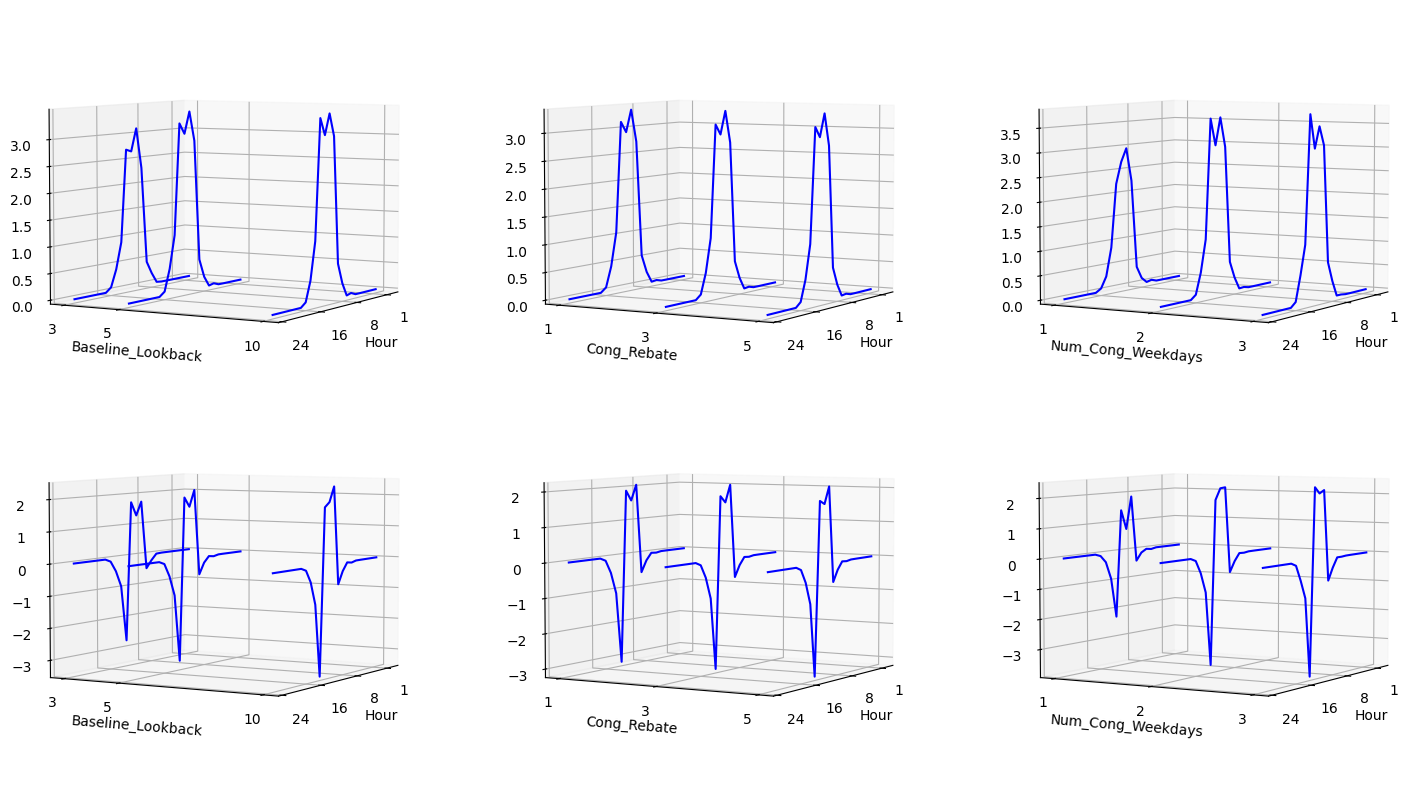

In [ ]:
# Step 3: Prepare Data for 3D Plotting
def prepare_data_for_3d_plot(comparison_df, parameter_name, data_column):
    grouped = comparison_df.groupby([parameter_name, 'Hour'])[data_column].mean().reset_index()
    pivot_table = grouped.pivot(index='Hour', columns=parameter_name, values=data_column)
    pivot_table = pivot_table.sort_index()
    return pivot_table

# Step 4: Generate 3D Surface Plot
def plot_3d_surface(ax, pivot_table, parameter_name, data_label):
    X_values = pivot_table.index.values.astype(float)
    Y_values = pivot_table.columns.values.astype(float)
    X, Y = np.meshgrid(X_values, Y_values)
    Z = pivot_table.values.T

    wire = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=0, color='b')

    ax.set_xlabel('Hour', labelpad=4)
    ax.set_ylabel(parameter_name, labelpad=4)

    # Set ticks to actual data values
    ax.set_xticks([1, 8, 16, 24])
    ax.set_yticks(Y_values)

    # Optional: Rotate tick labels for better readability
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='y', labelrotation=0)
    ax.dist = 13

# New function to create 3D surface plots
def create_3d_surface_plots(comparison_df, parameters, data_columns, data_labels):
    # Create subplots with enough spacing
    fig, axes = plt.subplots(nrows=len(data_columns), ncols=len(parameters), figsize=(15, 8), subplot_kw={'projection': '3d'})
    for i, data_column in enumerate(data_columns):
        for j, parameter_name in enumerate(parameters):
            pivot_table = prepare_data_for_3d_plot(comparison_df, parameter_name, data_column)
            ax = axes[i, j]
            plot_3d_surface(ax, pivot_table, parameter_name, data_labels[i])

            # Set the view angle for rotation (elevation and azimuth)
            ax.view_init(elev=5, azim=30)  # Adjust these values as needed

    # Adjust the spacing between subplots
    fig.subplots_adjust(top=1.2, bottom=0.25, hspace=-0)
    plt.show()

# Example usage
parameters = ['Baseline_Lookback', 'Cong_Rebate', 'Num_Cong_Weekdays']
data_columns = ['Baseline_Shift_Abs', 'Baseline_Shift']
data_labels = ['Absolute Baseline Shift', 'Baseline Shift']

# Call the function with your DataFrame
create_3d_surface_plots(comparison_df, parameters, data_columns, data_labels)